In [1]:
# Install catalax
# !pip install catalax

In [2]:
import json
import jax.numpy as jnp
import numpy as np

import catalax as ctx
import catalax.mcmc as cmc

import brainunit as u

In [3]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

def f(t, y, args):
    K_m, v_max  = args
    s1 = y * (u.molar / u.katal)
    d_s1 = - (v_max * s1) / (K_m + s1)
    return d_s1 / u.second

# Add term
model.add_term(f)

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0 * u.katal
model.parameters.K_m.value = 100.0 * u.molar

# Save the model
model.save("./models/", "menten_model")

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[v_max, K_m]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100. * molar,False,None,None,None,None
1,v_max,v_max,7. * katal,False,None,None,None,None


In [4]:

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
n_ds = 30

time = jnp.array([
    *[[10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 120],]*n_ds
]) * u.second

# Set initial conditions above and below the 
# true Km value for the sake of the example
initial_conditions = []

for _ in range(n_ds):
    initial_conditions += [
        {"s1": np.random.normal(300.0, 8.0) * u.katal},
        {"s1": np.random.normal(200.0, 8.0) * u.katal},
        {"s1": np.random.normal(80.0, 8.0) * u.katal},
        {"s1": np.random.normal(50.0, 8.0) * u.katal},
    ]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1 * u.second, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
data = np.random.normal(data.to_decimal(u.katal), 1.0).clip(min=0) * u.katal

# Turn intiial conditions into a matrix (Not yet part of the NeuralODE workflow)
y0s = model._assemble_y0_array(initial_conditions, in_axes=(0, None, None))


print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")

Time: (120, 6) | Data: (120, 6, 1) | Initial Conditions: (120, 1)


In [5]:
# Corrup the data to receive higher uncertainties
data = np.random.normal(data.to_decimal(u.katal), 5.0).clip(min=0) * u.katal

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (120, 6) | Data: (120, 6, 1)


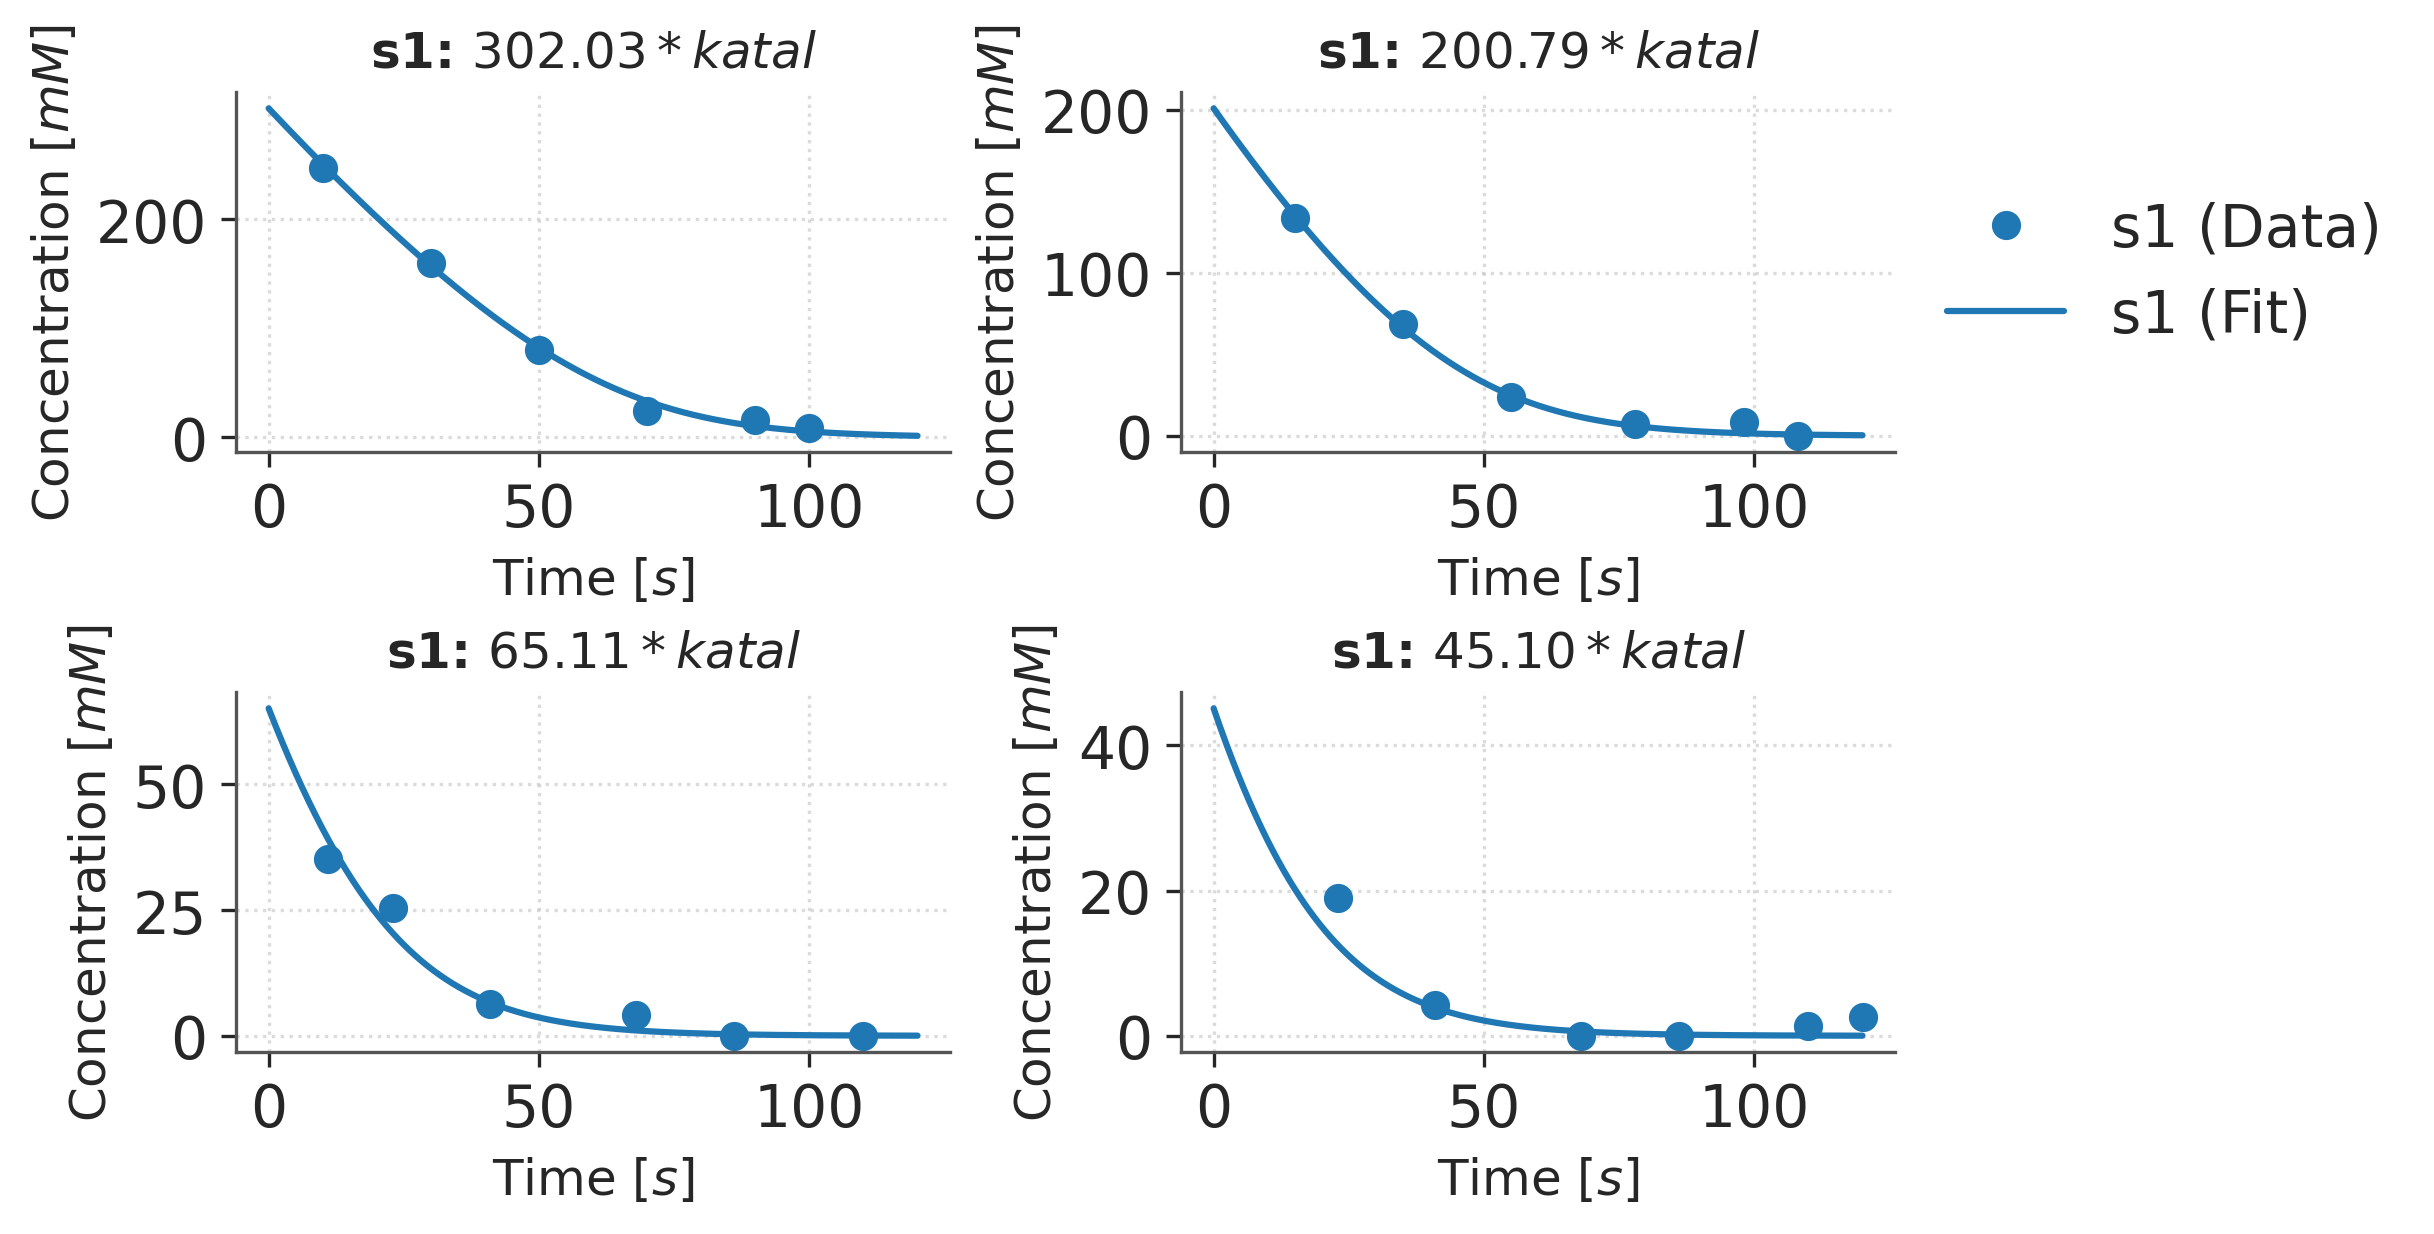

In [6]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)

In [7]:
# Define Priors
model.parameters.v_max.prior = cmc.priors.Uniform(low=1e-6, high=200.0, unit=u.katal)
model.parameters.K_m.prior = cmc.priors.Uniform(low=1e-6, high=1e3, unit=u.molar)

model.parameters.v_max.prior

# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [8]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1 * u.second,
    max_steps=64**4
)

🔸 Priors
├── v_max: U(low=1e-06, high=200.0, unit=kat)
├── K_m: U(low=1e-06, high=1000.0, unit=M)

🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [01:34<00:00, 21.09it/s, 7 steps of size 5.70e-01. acc. prob=0.93]




🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    103.82      3.01    103.70     99.21    109.05    719.17      1.00
     sigma      4.43      0.12      4.43      4.23      4.62    494.53      1.00
     v_max      7.12      0.09      7.11      6.98      7.27    748.72      1.00

Number of divergences: 0


In [9]:
# Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue
    
    model.parameters[param].value = float(samples.mean()) * model.parameters[param].prior.unit
    
model.parameters

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,103.817024 * molar,False,None,None,None,None
1,v_max,v_max,7.1175604 * katal,False,None,None,None,None


c:\routhleck_app\miniconda\envs\catalax\lib\site-packages\corner\core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
C:\Github\Catalax\catalax\mcmc\plotting.py:47: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


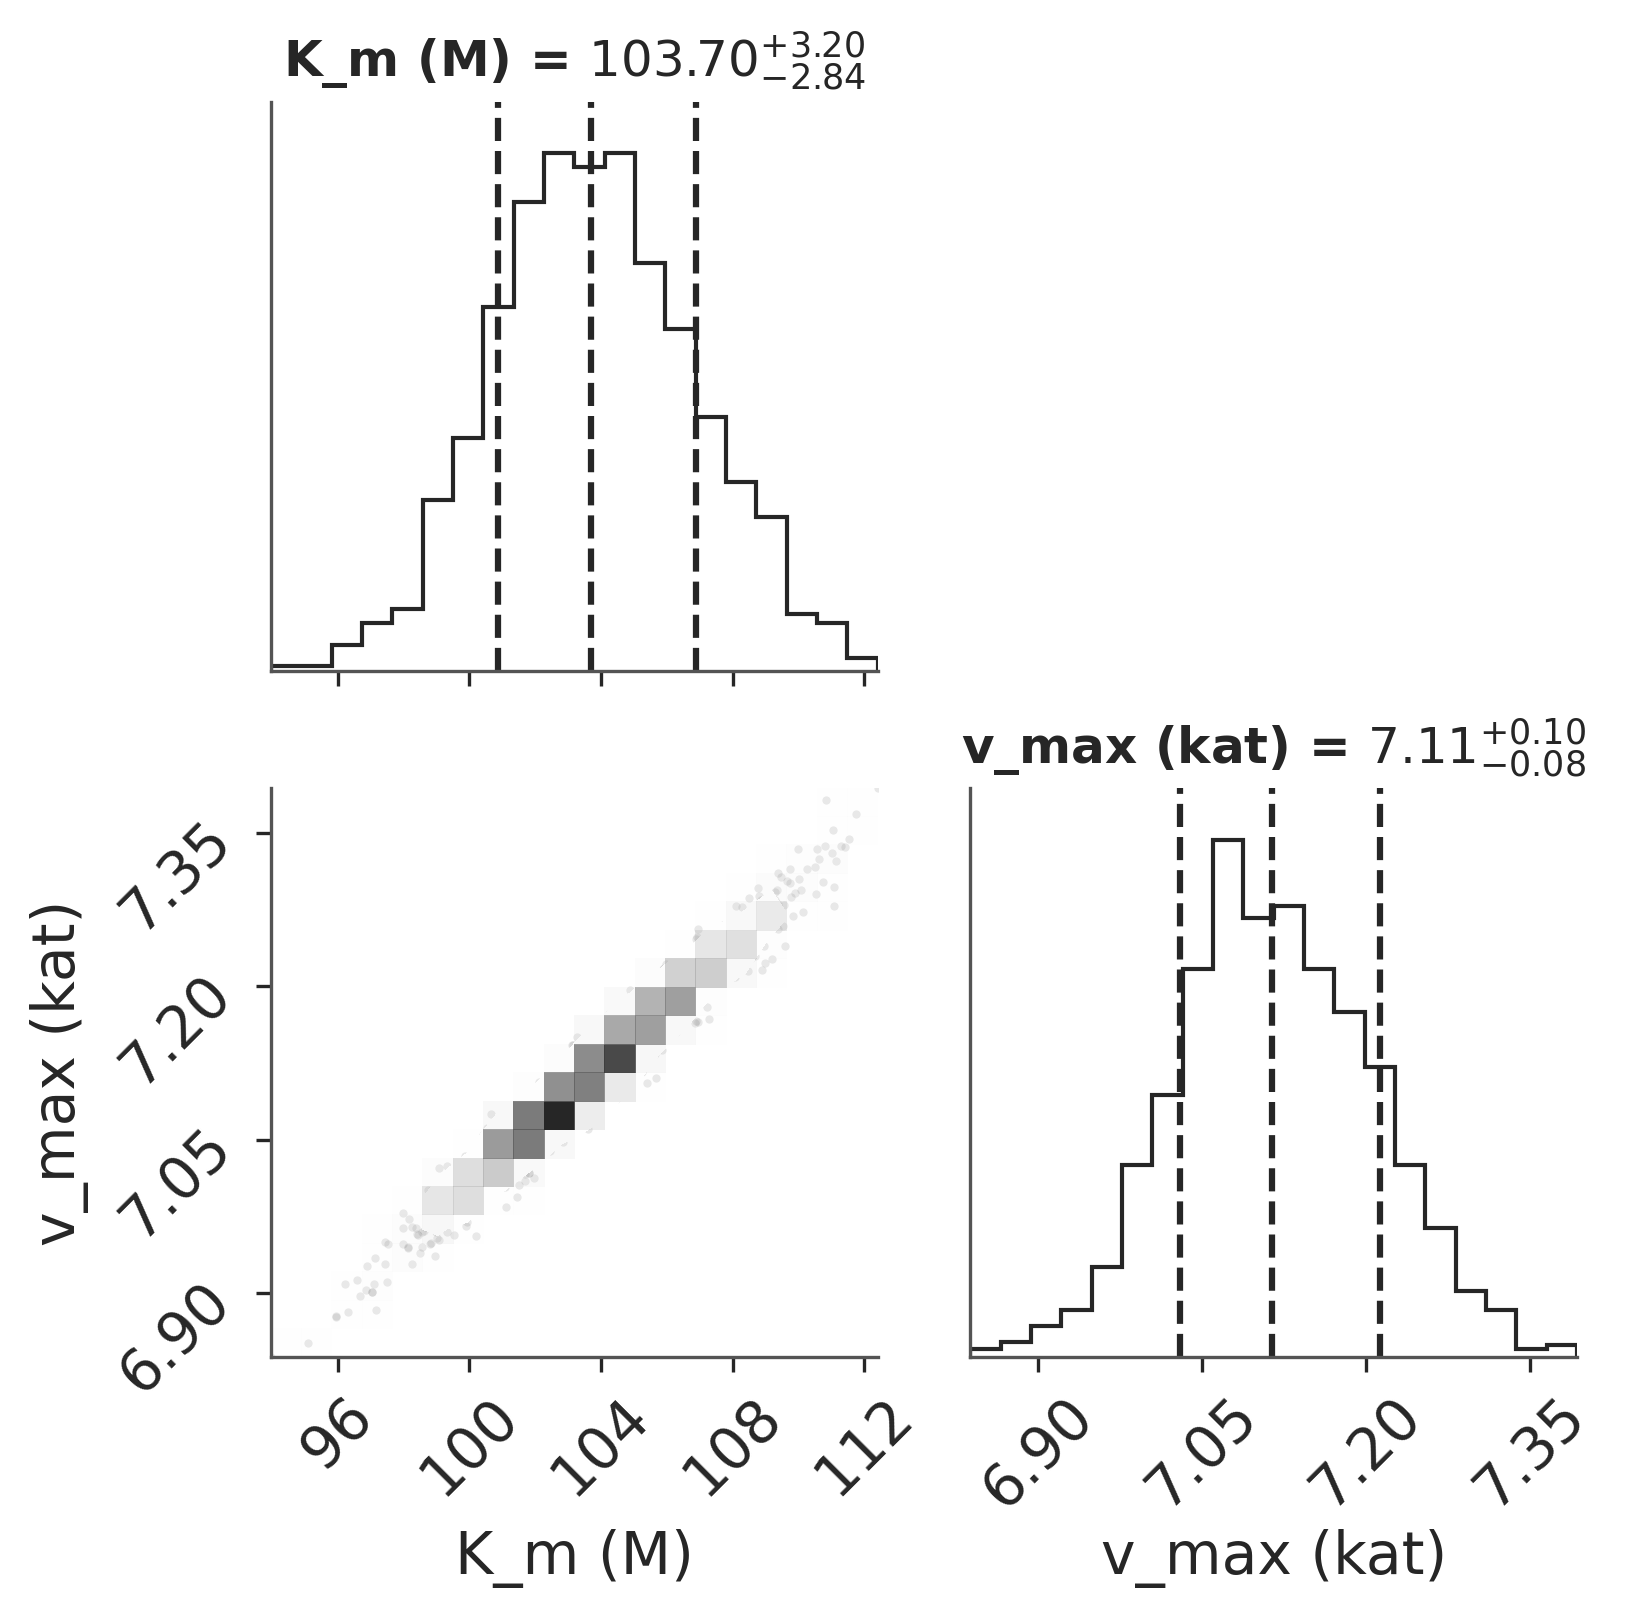

In [10]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc, model=model)

C:\Github\Catalax\catalax\mcmc\plotting.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


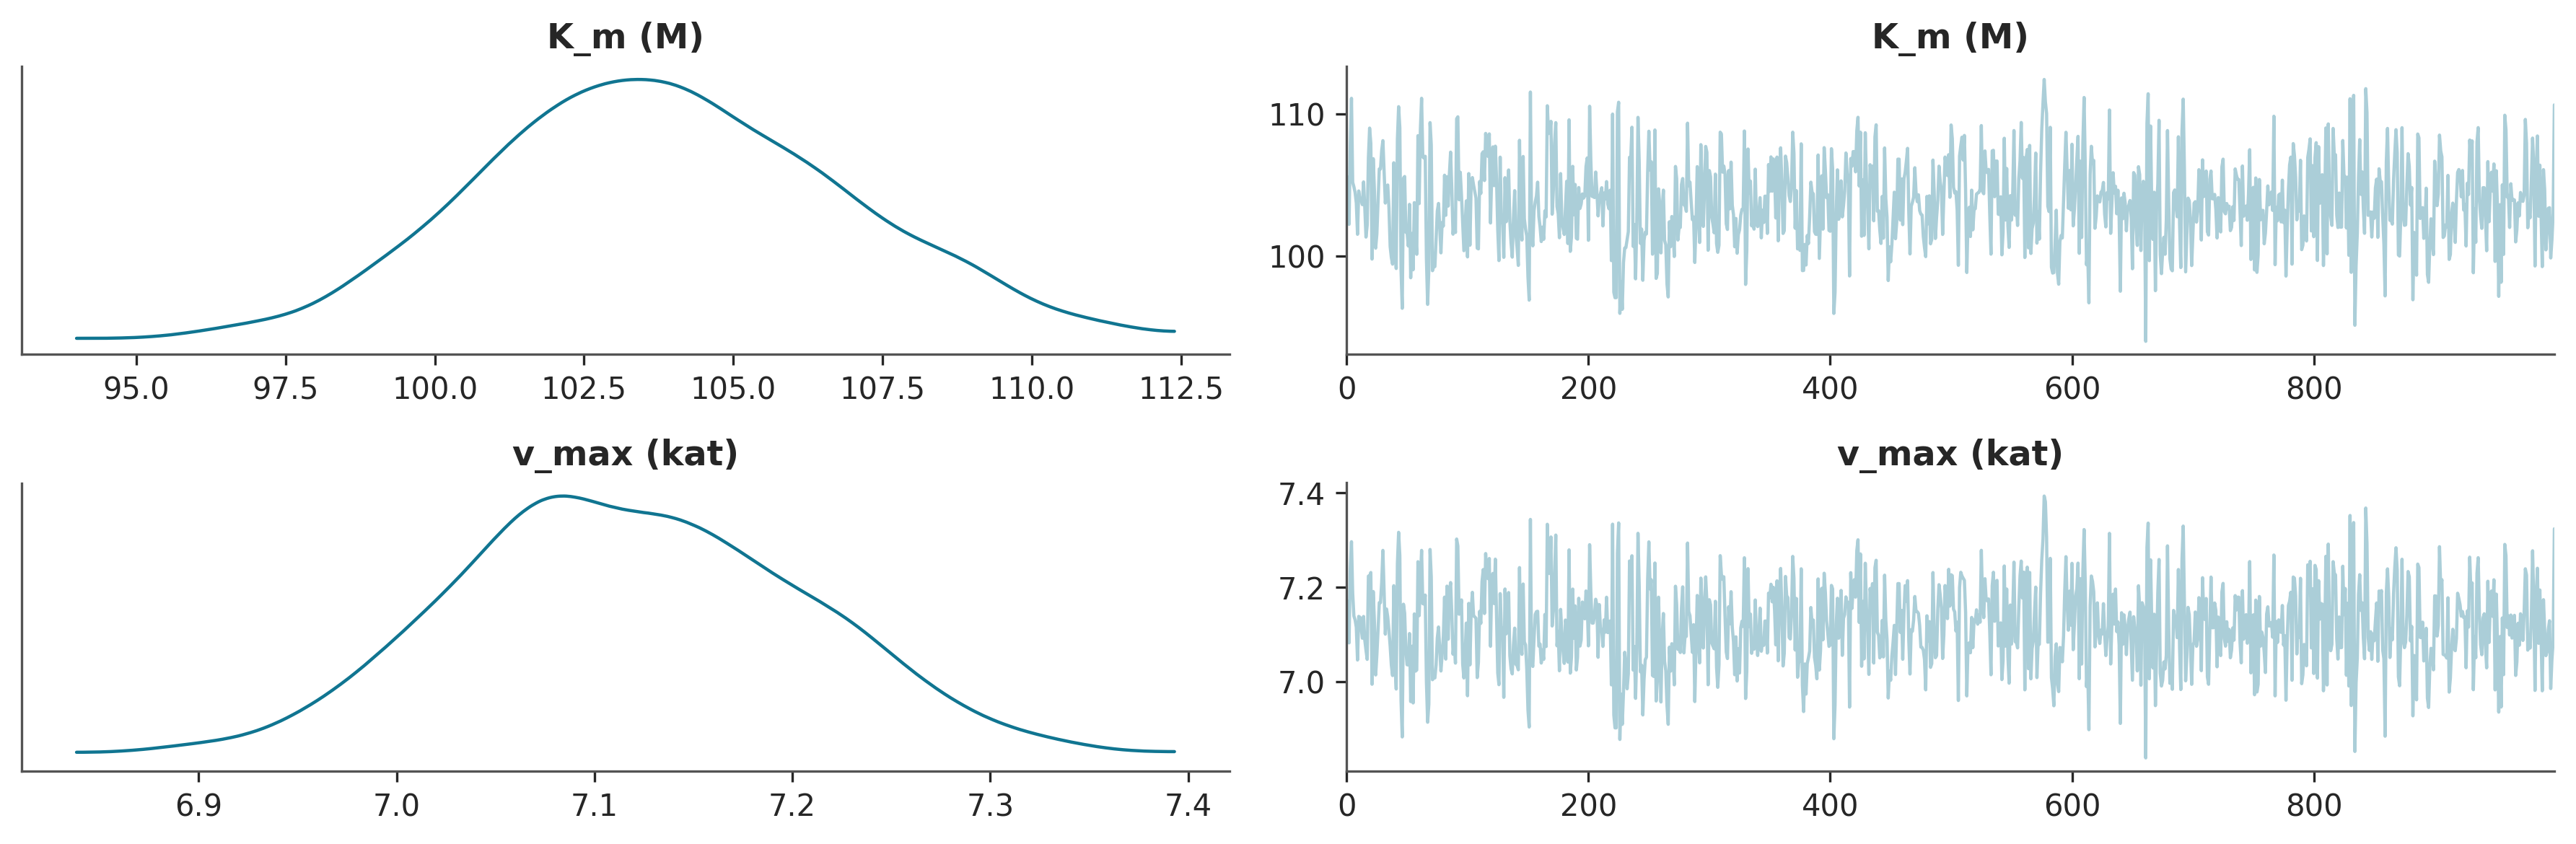

In [11]:
# Plot the trace of the MCMC (Posterior dist and chain trace)
f = cmc.plot_trace(mcmc, model)

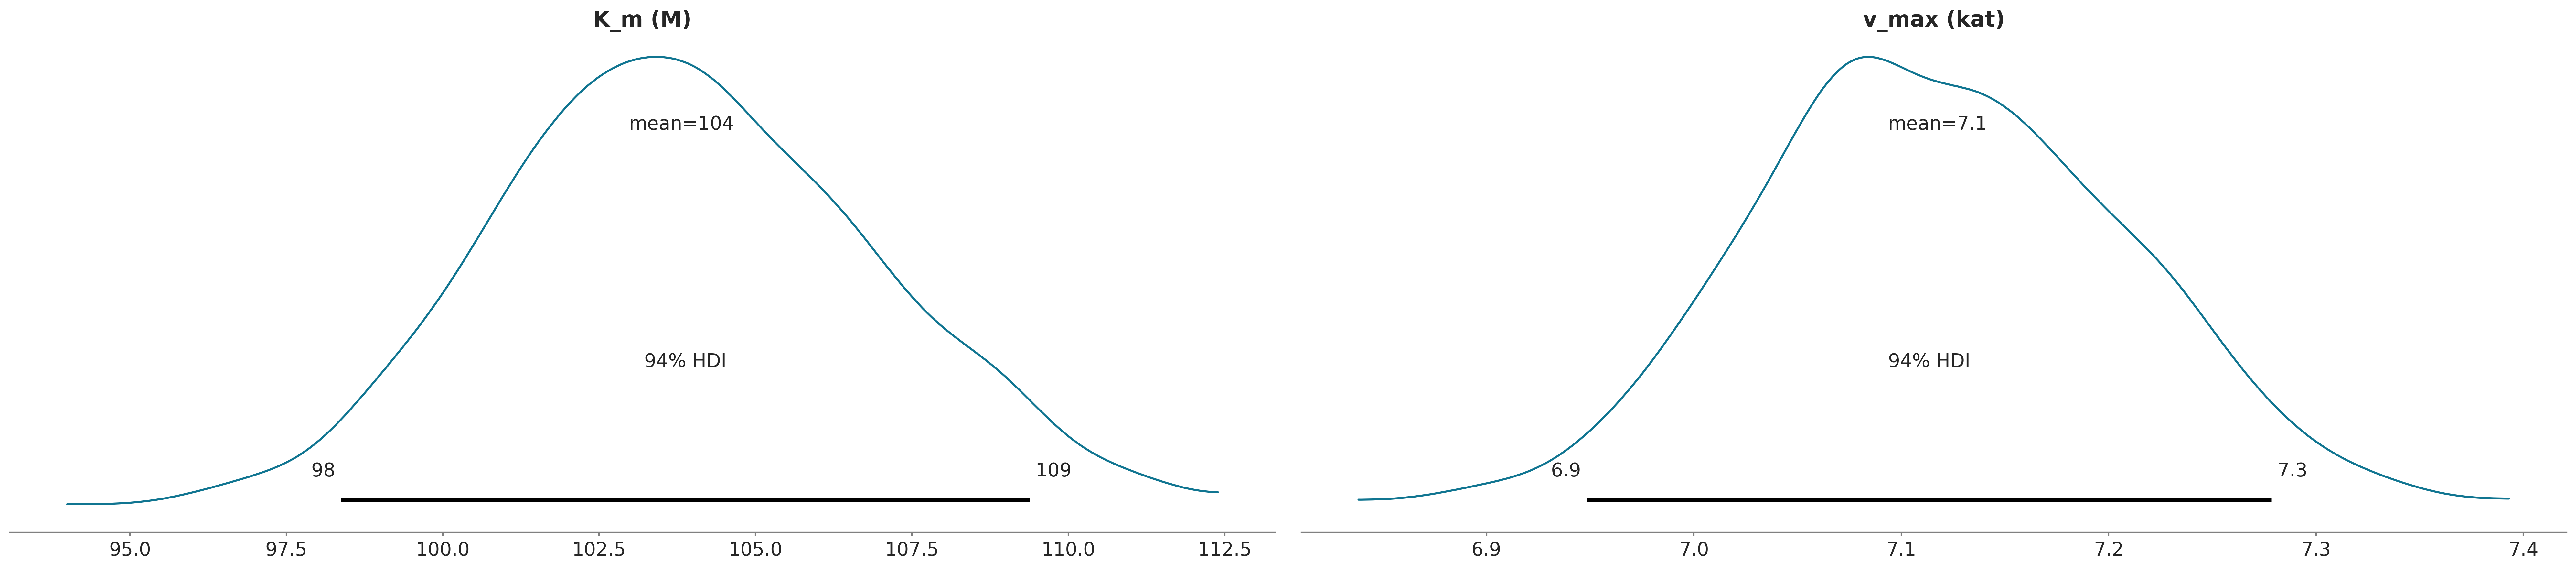

In [12]:
# Variant of plotting the posterior with HDPI
f = cmc.plot_posterior(mcmc, model)

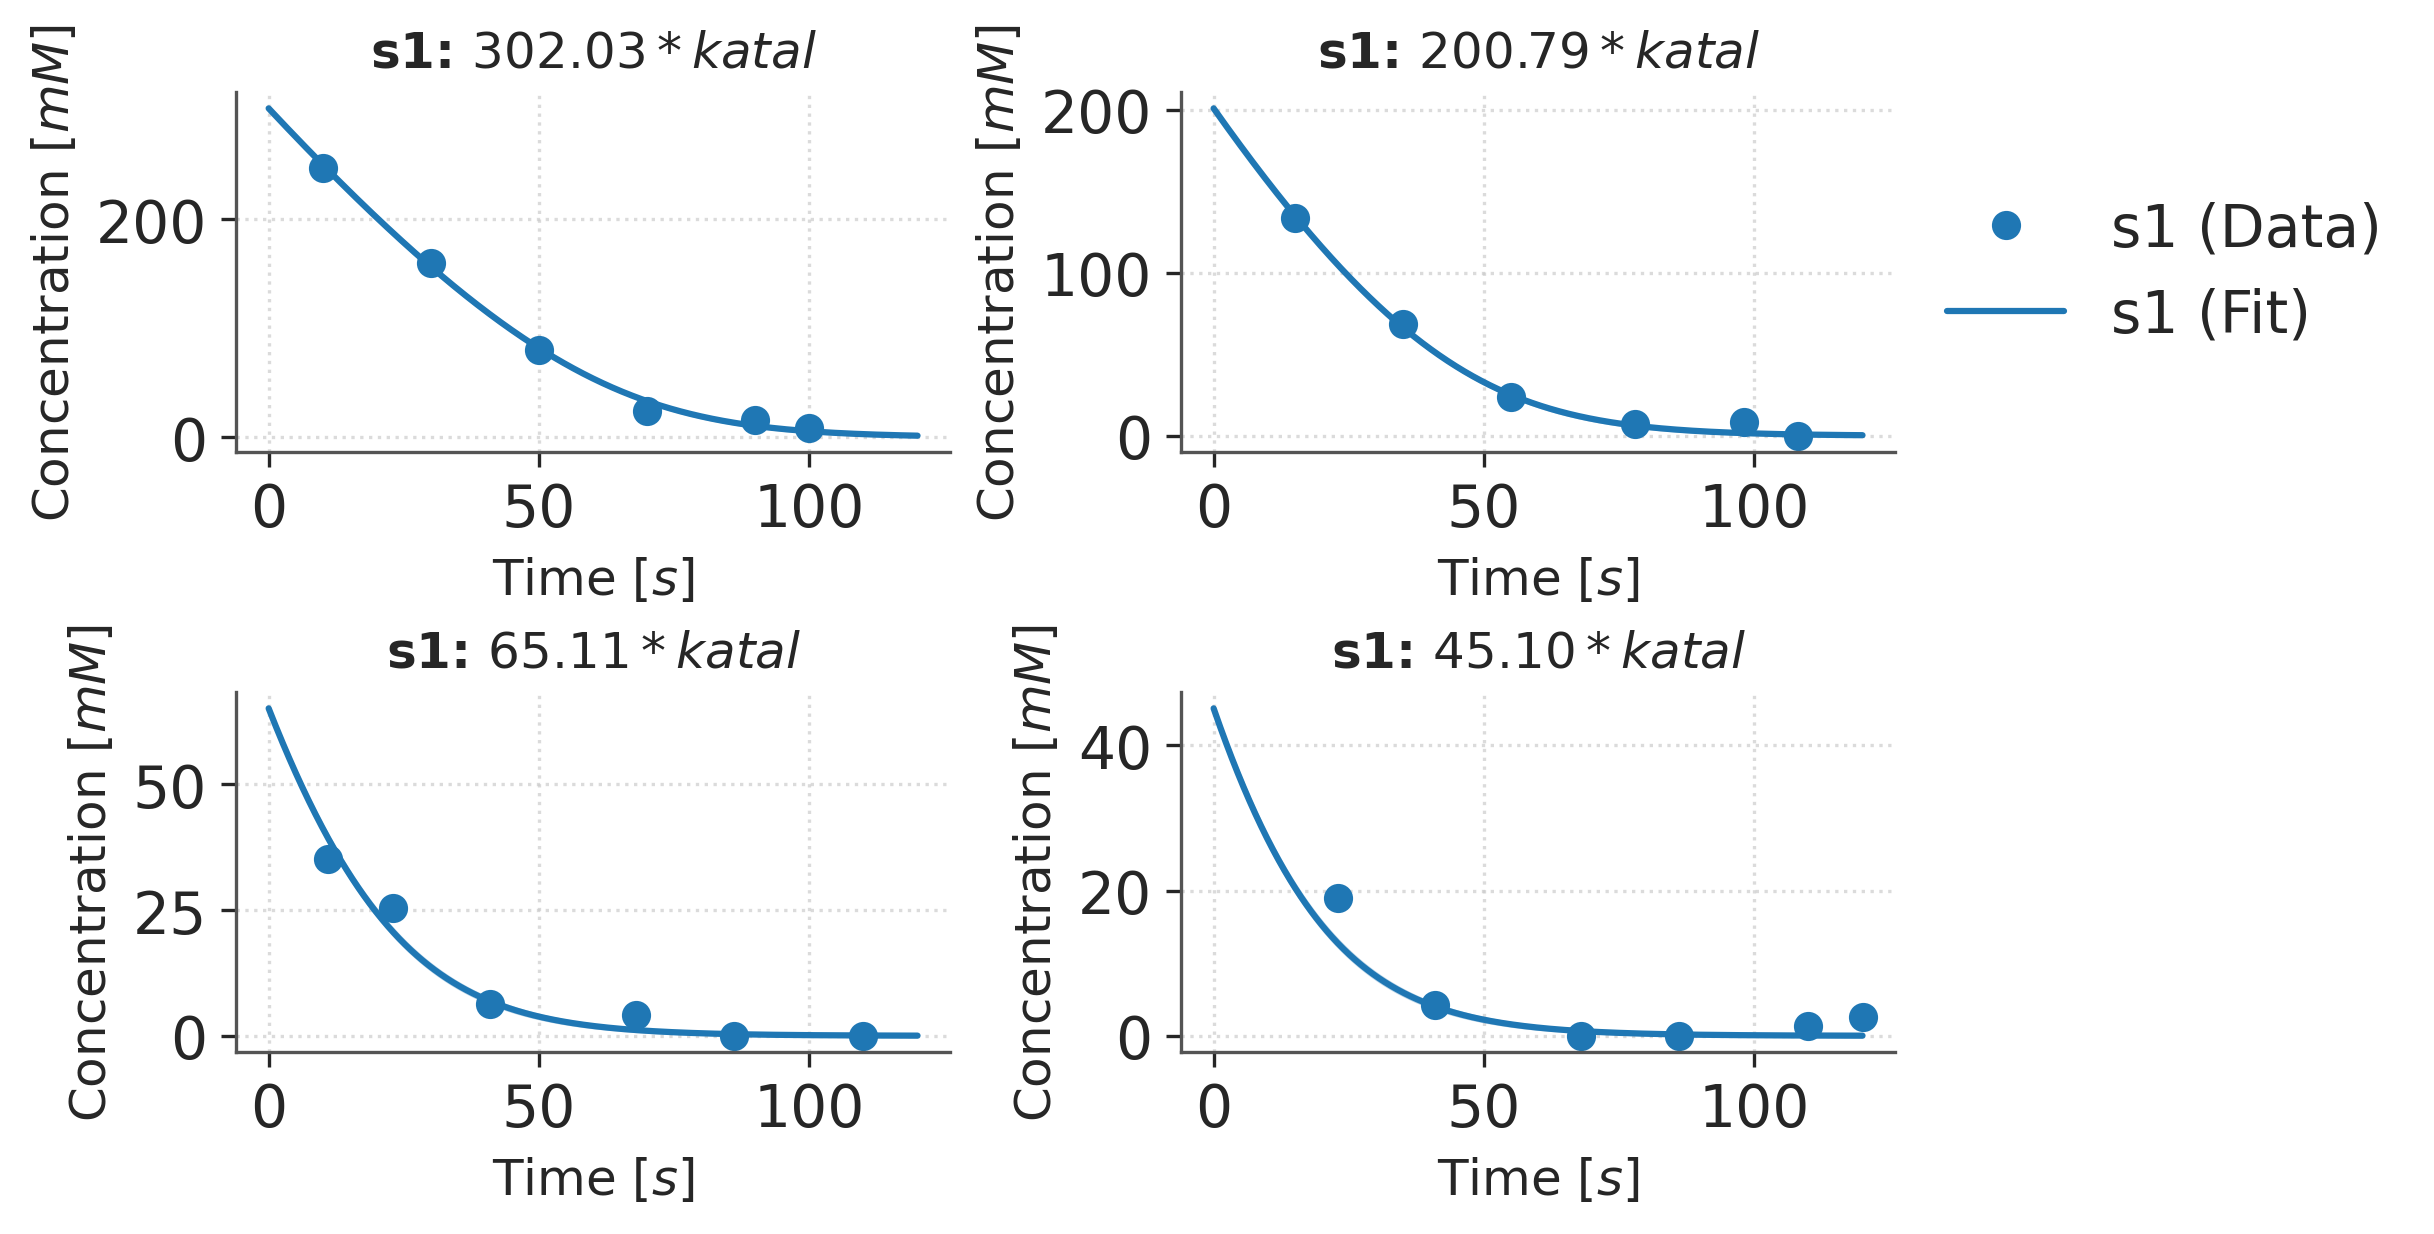

In [13]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#       
#      data = np.random.normal(data, 15.0).clip(min=0)
#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.


f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
    mcmc=mcmc
)